In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import wrangle_zillow
from prepare import prep_zillow
from prepare import remove_outliers
from prepare import tts_con
import explore as ex
import modeling as mod

import scipy.stats as stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

## Acquiring and preparing the data
* **wrangle_zillow**
    * pulls the raw data from the SQL server, removes nulls, and saves the data to a csv for ease of access in the future
* **prep_zillow** 
    * removes features that aren't necessary for exploration or modeling
* **remove_outliers** 
    * takes the data and calculates the IQR for each feature and the upper and lower fence. Any values outside those fences are considered outliers and removed

In [2]:
zillow=wrangle_zillow()
zillow=prep_zillow(zillow)
zillow, fences=remove_outliers(zillow)

In [3]:
#a look at the fences for the data
fences

,bath_count,bed_count,property_value,finished_sq_ft
upper_fence,4.5,5.5,1255866.75,3863.0
lower_fence,0.5,1.5,-443689.25,-289.0


### Splitting the data into train, validate, and test datasets

In [4]:
train, val, test=tts_con(zillow)

### Graphing the features in the train dataset

bath_count


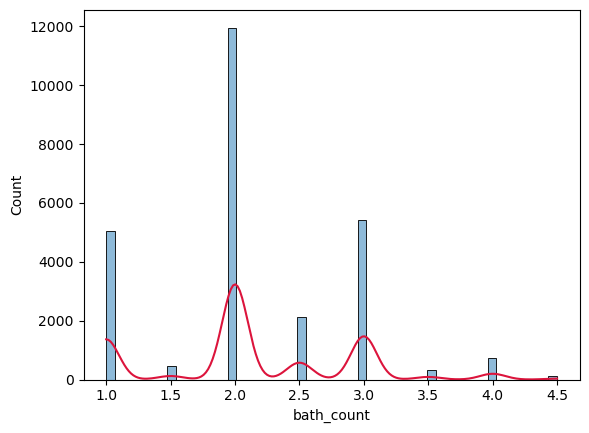

bed_count


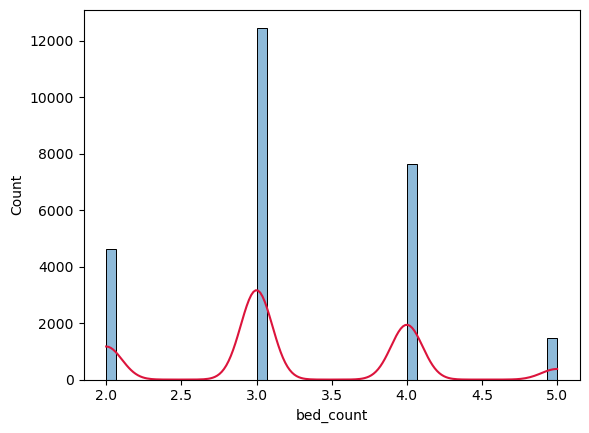

property_value


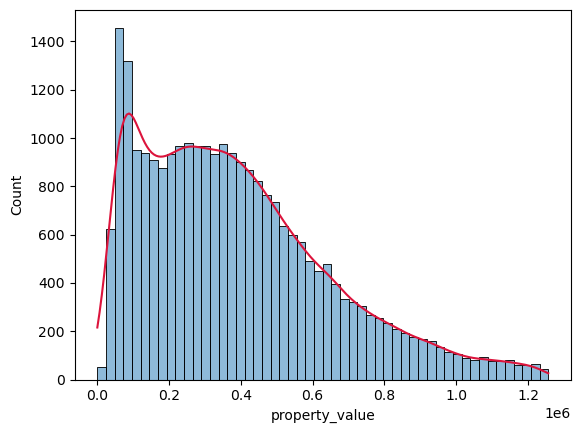

finished_sq_ft


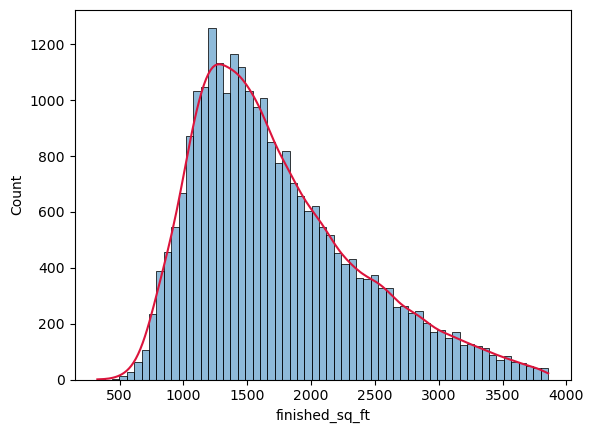

In [5]:
ex.feature_graphs(train)

## Takeaways for exploration:
* Finished square feet is almost a normal distribution.  
* Can invistigate homes with 2 bath and 3 bedrooms
    * Compare the property value of homes with 2 bathrooms to the overall property value mean of the dataset (single sample ttest)
    * Compare the property value of homes with 3 bedrooms to the overall property value mean of the dataset (single sample ttest)
* Subset and investigate homes with <=3 and >3
    * Compare their means (2 sample/independent ttest)  
* What is the corrlation between finished square feet and property value
    * How strong is the correlation between finished square feet and property value (Pearsonr)

# Exploration

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 1:</h2>
    </header>
    <dl>
        <dt>Is the property value of homes that have 2 bathrooms significantly lower than the mean of all homes?</dt>
        <dd>- $H_0$: There is no difference in between the property value of homes that have <strong>2 bathrooms</strong> the mean property value of all homes</dd>
        <dd>- $H_a$: The property value of homes with <strong>2 bathrooms</strong> is significantly lower than the mean of all homes</dd>
    </dl>
</div>

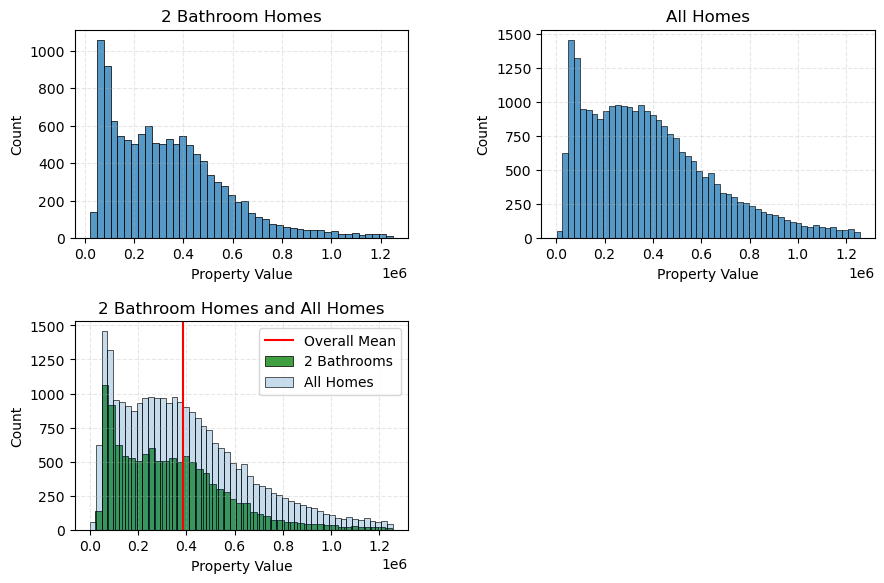

In [6]:
#visualize the features
ex.eq1_graphs(train)

In [7]:
ex.eq1_statistic(train)

t statistic= -24.24
p-value= 4.3036527011951066e-127
alpha= 0.05
Reject the null hyopthesis


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with 2 bathrooms is significantly lower than the average home in this dataset

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 2:</h2>
    </header>
    <dl>
        <dt>Is the property value of homes that have 3 bedrooms significantly lower than the mean of all homes?</dt>
        <dd>- $H_0$: There is no difference in between the property value of homes that have <strong>3 bedrooms</strong> the mean property value of all homes</dd>
        <dd>- $H_a$: The property value of homes with <strong>3 bedrooms</strong> is significantly lower than the mean of all homes</dd>
    </dl>
</div>

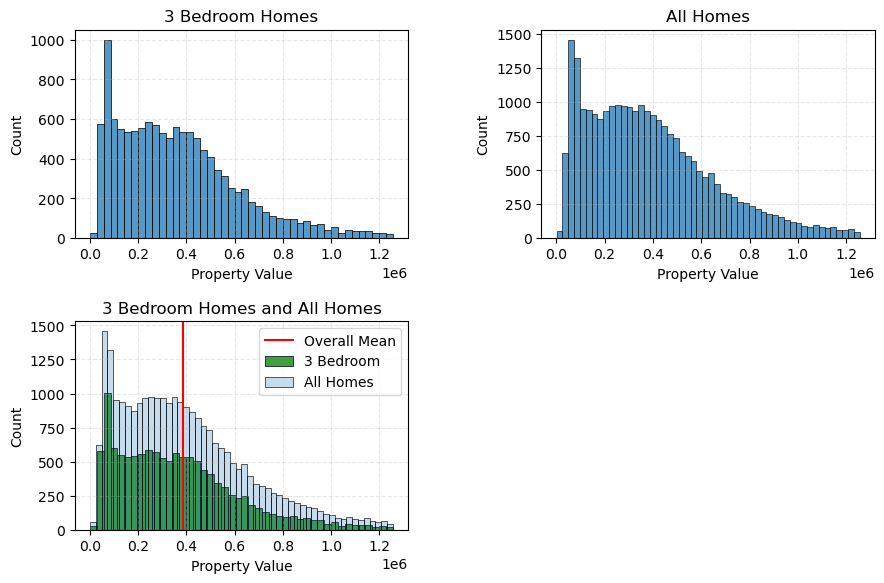

In [8]:
ex.eq2_graphs(train)

In [9]:
ex.eq2_statistic(train)

t statistic= -10.95
p-value= 4.382698658471545e-28
alpha= 0.05
Reject the null hyopthesis


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with 3 bedrooms is significantly lower than the average home in this dataset

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 3:</h2>
    </header>
    <dl>
        <dt>Is the mean property value of homes that have less than 3.5 bedrooms significantly less than the mean of homes with greater than 3.5 bedrooms?</dt>
        <dd>- $H_0$: There is no difference in between the mean property value of homes that have <strong>less than 3.5</strong> bedrooms compared to the mean of homes with <strong>greater than 3.5</strong> bedrooms</dd>
        <dd>- $H_a$: The mean property value of homes that have <strong>less than 3.5</strong> bedrooms is significantly less compared to the mean of homes with <strong>greater than 3.5</strong> bedrooms</dd>
    </dl>
</div>

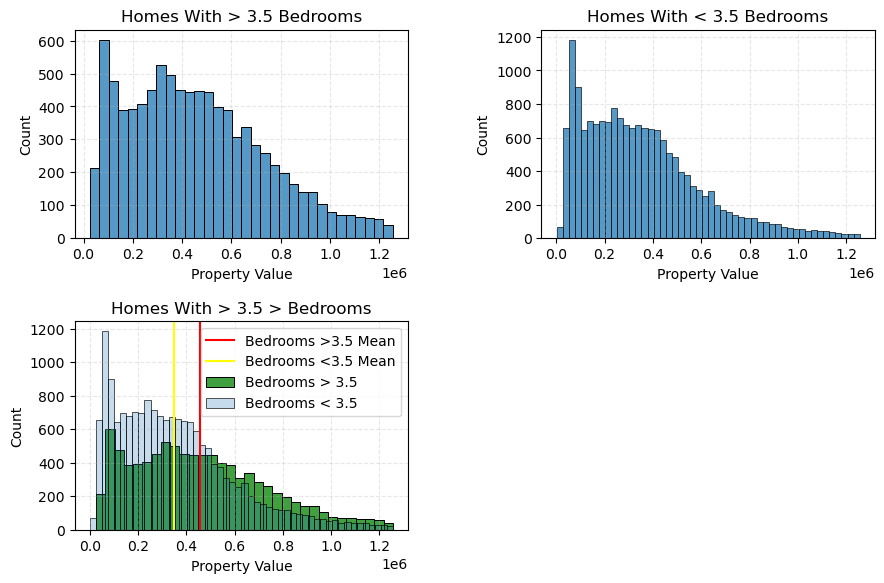

In [10]:
ex.eq3_graphs(train)

In [11]:
ex.eq3_statistic(train)

Variance of property values for homes with more than 3 bedrooms: 77008453855.60184
Variance of property values for homes with less than 3 bedrooms: 60139586016.19634
t statistic= -31.34
p-value= 6.457898195742378e-210
alpha= 0.05
Reject the null hyopthesis


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with less than 3.5 (<=3) bedrooms is significantly lower than houses with greater than 3.5 (>3) bedrooms
    * This further builds on the second explore question that only looked at houses with 3 bedrooms

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 4:</h2>
    </header>
    <dl>
        <dt>Is there a correlation between finished square feet and property value? If so, how strong?</dt>
        <dd>- $H_0$: There is <strong>no correlation</strong> between finished square feet and property value</dd>
        <dd>- $H_a$: There is a <strong>correlation</strong> between finished square feet and property value</dd>
    </dl>
</div>

In [12]:
c=ex.eq4_corr(train)

The correlation between property value and finished square feet is 0.47769311891989136


In [13]:
c

,bath_count,bed_count,property_value,finished_sq_ft
bath_count,1.000000,0.590137,0.403174,0.788924
bed_count,0.590137,1.000000,0.212064,0.610271
property_value,0.403174,0.212064,1.000000,0.477693
finished_sq_ft,0.788924,0.610271,0.477693,1.000000


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that there is a moderate correlation between the property value and finished square feet

<div class="alert alert-info">
    <header>
    <h2>Exploration Takeaways</h2>
    </header>
    <dl>
        <dt>I can confidently say I have found several features to be drivers effecting property value</dt>
        <dd>- Homes with two bathrooms will have a property value significantly lower than average</dd>
        <dd>- Homes with three bedrooms have a property value significantly lower than average</dd>
        <dd>- Homes with three or less bedrooms have a significantly lower average property value compared to homes that have more than three bedrooms. This corroberates the analysis done on homes with only 3 bedrooms</dd>
        <dd>- I found there was a moderate correlation between finished square feet and property value. There was a correlation of .478; maybe there is another feature with a stronger correlation that can be pulled from the SQL server</dd>
    </dl>
</div>

# Modeling

### Introduction
* First, the data was acquired and prepared the same way for explore
* Some additional alterations weremade for modeling
    * Dummies were made for bedroom count and bathroom count
    * finished square feet was scaled using a standard scalar

In [14]:
#Prepare the data for modeling
X_train, y_train, X_val, y_val, X_test, y_test = mod.prep_for_modeling()

In [15]:
X_train.head(3)

,finished_sq_ft,bed_count_2.0,bed_count_3.0,bed_count_4.0,bed_count_5.0,bath_count_1.0,bath_count_1.5,bath_count_2.0,bath_count_2.5,bath_count_3.0,bath_count_3.5,bath_count_4.0,bath_count_4.5
32057,-0.797661,0,1,0,0,0,0,1,0,0,0,0,0
43708,-0.900668,1,0,0,0,1,0,0,0,0,0,0,0
2083,-0.680818,0,1,0,0,0,1,0,0,0,0,0,0


### Model Generation
* Several models were created during the modeling phase
    * Linear Regression (OLM)
    * Lasso Lars
    * Tweedie Regression (GLM)
    * Polynomal Regression
* The models were compared
    * RMSE was calculated for all of them and compared to the baseline
    * The difference was calculated to pick the top performing model

In [16]:
y_train, y_val = mod.get_baseline(y_train, y_val)

Train RMSE for the median baseline is 265529.7383407816
Train RMSE for the mean baseline is 262061.4513771557


Validate RMSE for the median baseline is 268295.544925074
Validate RMSE for the mean baseline is 264235.4144336938


   * The mean baseline RMSE was slightly lower so the median baseline was dropped

In [17]:
y_train, y_val = mod.models(X_train, y_train, X_val, y_val)

In [18]:
rmsedf = mod.model_rmse(y_train, y_val)
rmsedf

,Model,RMSE Train,RMSE Validate,Train/Validate Difference
1,Linear Regression,226521.171742,227107.371795,586.200053
2,Lasso Lars,226519.17107,227114.187643,595.016573
4,Polynomial Regression,226173.932596,227161.743853,987.811256
3,Tweedie Regressor,237572.982168,238732.274473,1159.292305
0,Baseline Mean,262061.451377,264235.414434,2173.963057


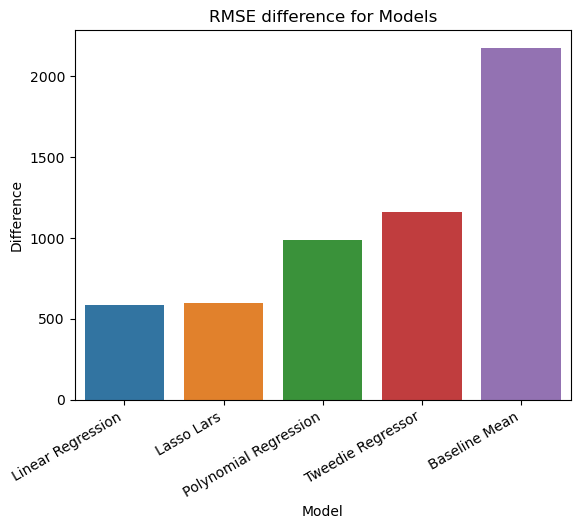

In [19]:
mod.rmse_viz(rmsedf)

<div class="alert alert-info">
    <header>
    <h2>Modeling Takeaway</h2>
    </header>
    <dl>
        <dt>Several models were made and we can select a model to run our test data</dt>
        <dd>- All models performed better than the baseline</dd>
        <dd>- The RMSE for polynomial regression was the lowest of all the models at 226173.93</dd>
        <dd>- The difference between the train and validate RMSE was smallest on the linear regression model and the train was very close to the polynomial regression model (226521.17)</dd>
        <dd>- Because the difference in RMSE is smaller for linear regression, I will use that model for the test set</dd>
    </dl>
</div>

In [20]:
mod.model_test(X_train, y_train, X_test, y_test, rmsedf)

,Model,RMSE Train,RMSE Validate,Train/Validate Difference,RMSE Test
1,Linear Regression,226521.171742,227107.371795,586.200053,230232.389856


<div class="alert alert-info">
    <header>
    <h2>Conclusion</h2>
    </header>
    <dl>
        <dt>Our test data ran similar to our train and validate</dt>
        <dd>- RMSE was similar to the other sets</dd>
        <dt>Recommendations</dt>
        <dd>- When predicting homes, I recommend focusing on focusing on the number of <strong>bedrooms</strong> and <strong>bathrooms</strong> they have. There was a significant difference in homes with two bathrooms and three/three or less bedrooms.</dd>
        <dd>- Overall finished square feet does show a moderate correlation and can be used to make predictions, but should not be relied on.</dd>
        <dt>Next Steps</dt>
        <dd>- If I had more time, location would be interesting to analyze. Does location have any relationship with other features?</dd>
        <dd>- I would also try to find another feature with a stronger correlation to property value than finished square feet</dd>
        <dd>- I would combine two of the explore questions and test the mean of homes with 2 bathrooms and 3 bedrooms against the overall mean</dd>
    </dl>
</div>